# Stock Price predictor for ITC

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import statsmodels.api as sm
%matplotlib inline

In [2]:
#------------------------Loading Data---------------------
data = pd.read_csv('ITC.NS.csv',header=[0],parse_dates=[0])

In [3]:
data.head(1)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-01-01,29.309999,31.488899,26.9333,30.2556,3.723604,509287590


In [4]:
data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
#--------------------Date time feature extraction---------------
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month

In [6]:
data = data.set_index('Date')

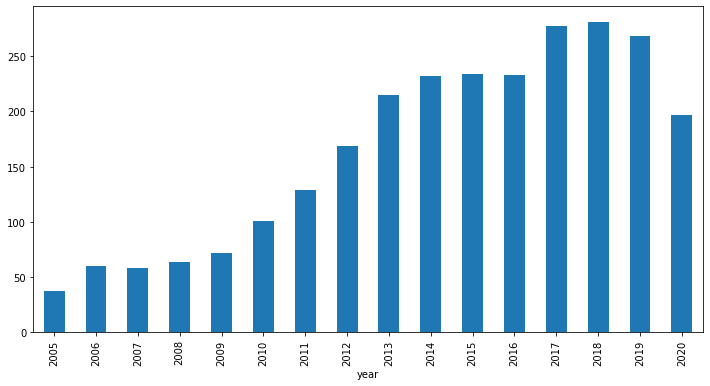

In [7]:
plt.figure(figsize=(12,6))
data.groupby('year')['Close'].mean().plot.bar()

In [8]:
train = data.ix['2005-01-01':'2017-12-31']
test = data.ix['2018-01-01':'2019-12-31']

# --------------------Data Visualization-----------------

In [9]:
years = train['year'].unique()

# Prep Colors
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

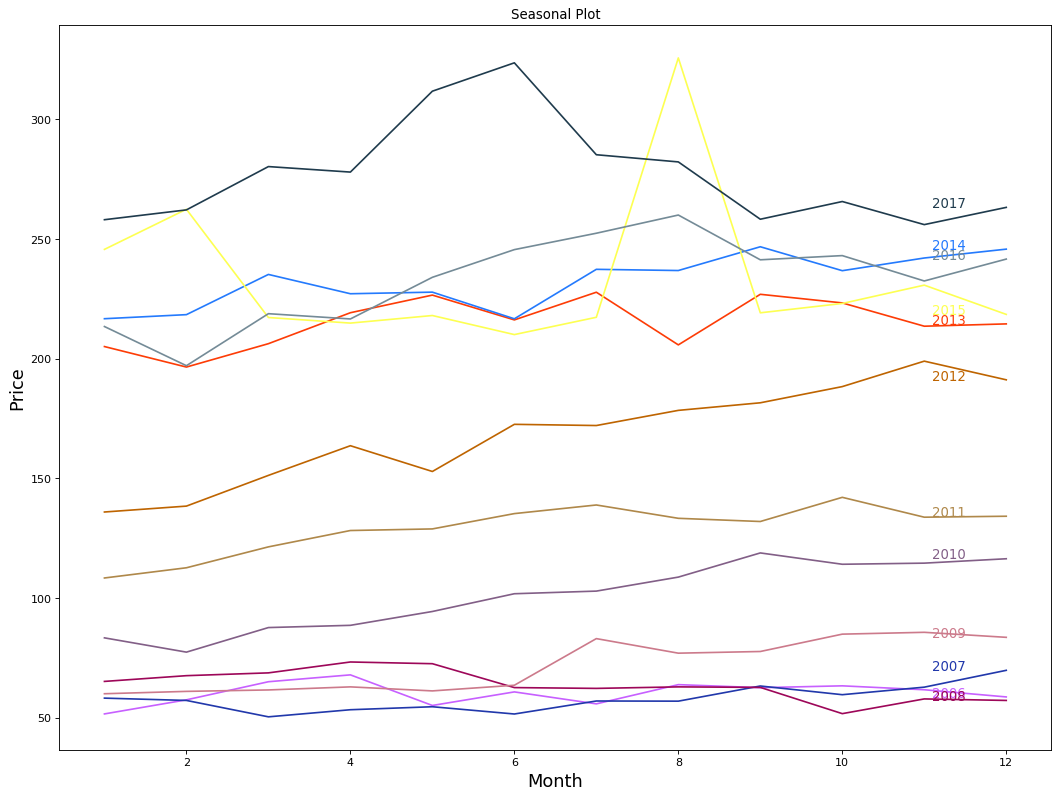

In [10]:
# Draw Plot
plt.figure(figsize=(16,12), dpi= 80)
plt.title('Seasonal Plot')
plt.ylabel('Price',fontsize=16)
plt.xlabel('Month',fontsize=16)
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'Close', data=train.loc[train.year==y, :], color=mycolors[i], label=y)
        plt.text(train.loc[train.year==y, :].shape[0]-.9, train.loc[train.year==y, 'Close'][-1:].values[0], y, fontsize=12, color=mycolors[i])

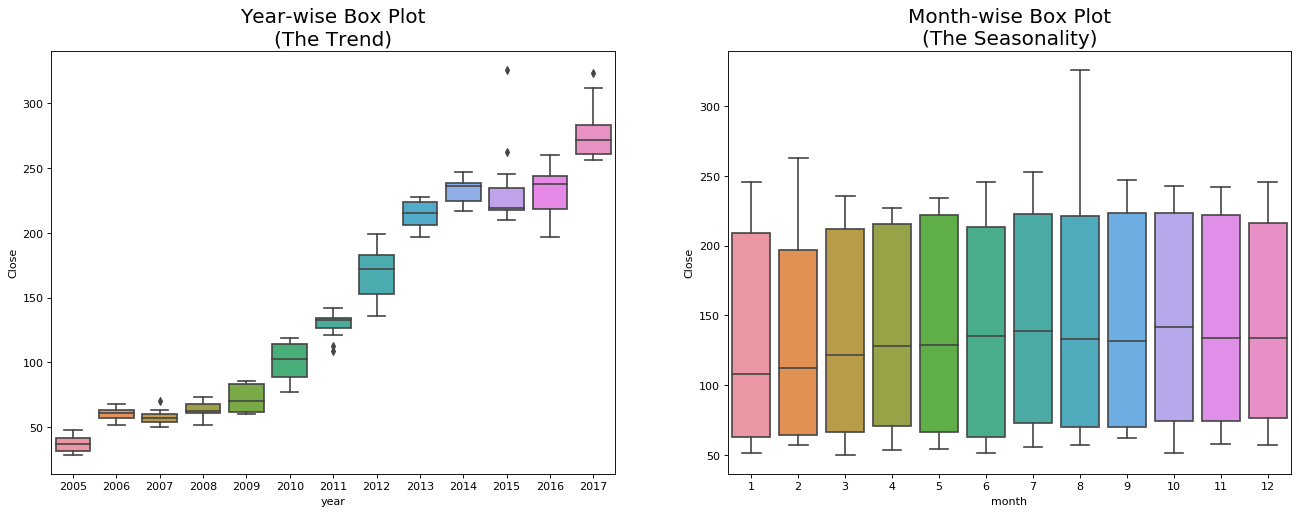

In [11]:
# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='Close', data=train, ax=axes[0])
sns.boxplot(x='month', y='Close', data=train.loc[~train.year.isin([2005, 2017]), :])

# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18)
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

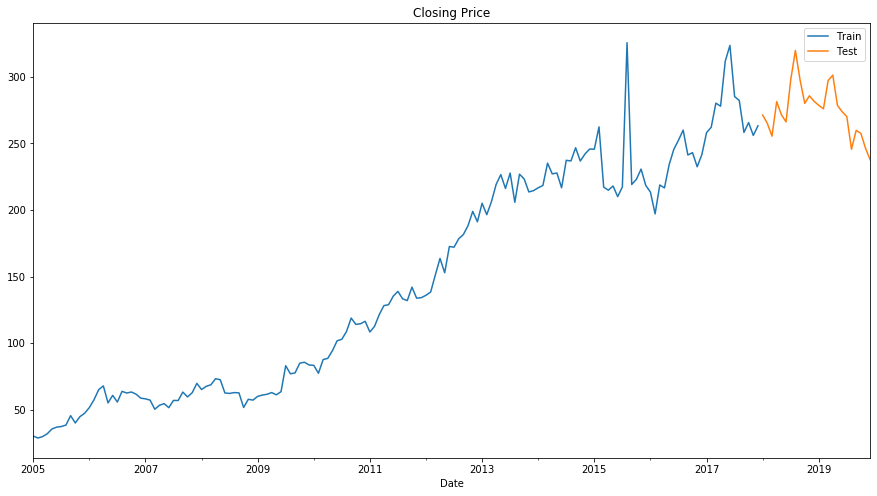

In [12]:
train.Close.plot(figsize=(15,8),title='Closing Price',label='Train')
test.Close.plot(figsize=(15,8),title='Closing Price',label='Test')
plt.legend(loc='best')

# --------------------Exponential Smoothing Model-------------------------

In [13]:
from statsmodels.tsa.api import ExponentialSmoothing,SimpleExpSmoothing

In [14]:
yhat = test.copy()

In [15]:
Ses = SimpleExpSmoothing(np.asarray(train['Close'])).fit(smoothing_level=0.2,optimized=False)
Ses2 = SimpleExpSmoothing(np.asarray(train['Close'])).fit()

In [16]:
yhat['SES'] = Ses.forecast(len(test)) 
yhat['SES2'] = Ses2.forecast(len(test))

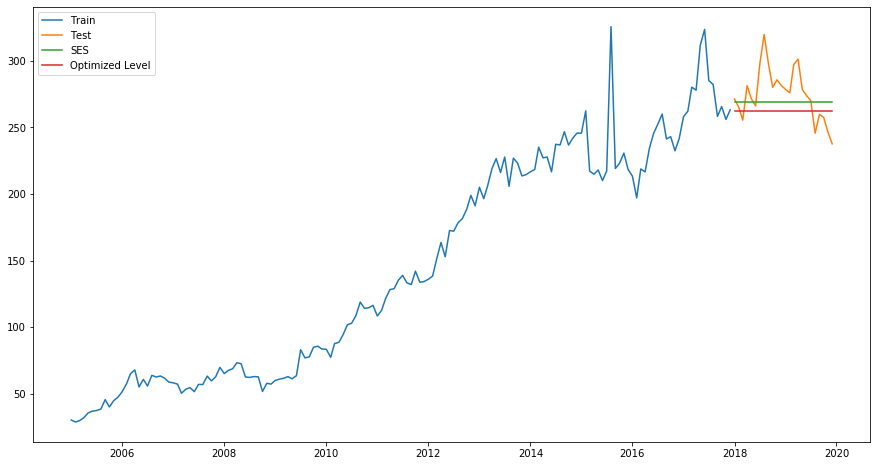

In [17]:
plt.figure(figsize=(15,8))
plt.plot(train.Close,label='Train')
plt.plot(test.Close,label='Test')
plt.plot(yhat['SES'],label='SES')
plt.plot(yhat['SES2'],label='Optimized Level')
plt.legend(loc='best')

In [18]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test.Close, yhat['SES2'])
mse

520.5584399370464

In [19]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test.Close, yhat['SES'])
mse

393.8098616481886

# ----------Holt's Linear Trend and Exponential model-----------------

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.holtwinters import Holt

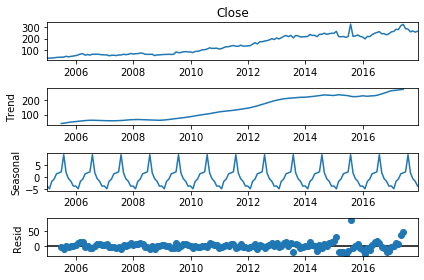

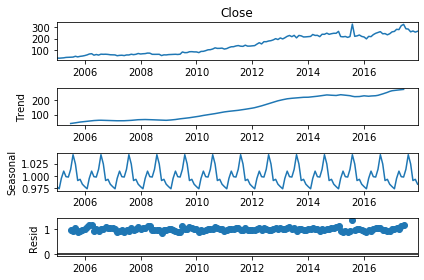

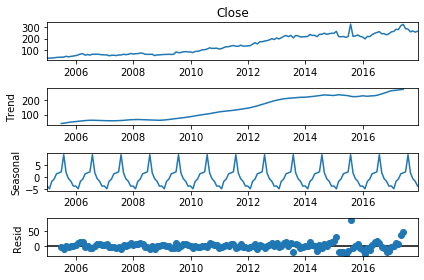

In [21]:
seasonal_decompose(train['Close'],model='multiplicative').plot()
seasonal_decompose(train['Close'],model='additive').plot()

In [22]:
yhat = test.copy()

In [23]:
fit1 = Holt(np.asarray(train['Close'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
yhat['Holt_linear'] = fit1.forecast(len(test))

In [24]:
fit2 = Holt(np.asarray(train['Close']), exponential=True).fit(smoothing_level=0.8, smoothing_slope=0.1, optimized=True)
yhat['Holt_exponential']= fit2.forecast(len(test))

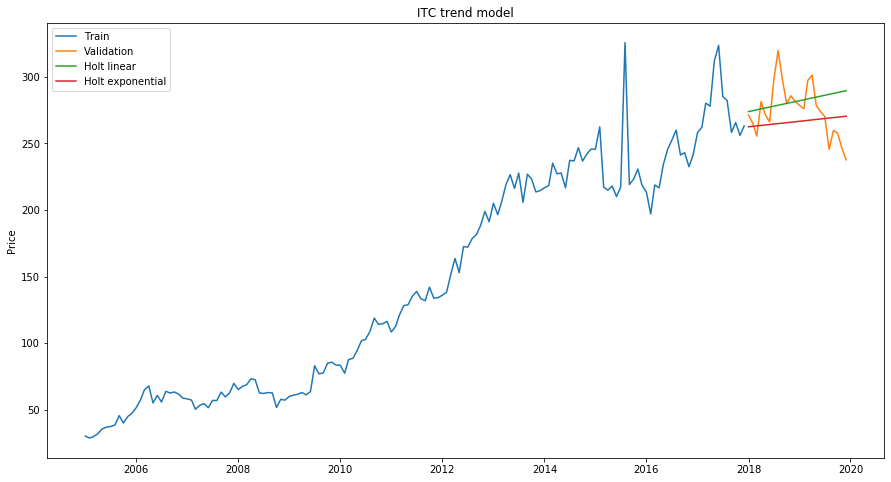

In [25]:
plt.figure(figsize=(15,8))
plt.plot(train.Close,label='Train')
plt.plot(test.Close,label='Validation')
plt.plot(yhat['Holt_linear'],label='Holt linear')
plt.plot(yhat['Holt_exponential'],label='Holt exponential')
#plt.plot(test['Close'],label='Test')
plt.ylabel('Price')
plt.title('ITC trend model')
plt.legend(loc='best')

# --------------------- Holts winter trend+seasonal model------------------

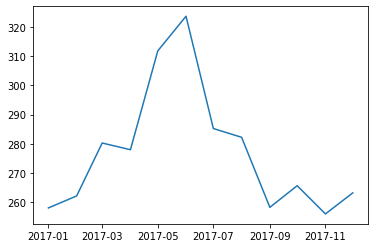

In [26]:
plt.plot(train['Close']['2017-01-01':'2017-12-31'])

In [27]:
yhat = test.copy()

fit1 = ExponentialSmoothing(np.asarray(train['Close']) ,seasonal_periods=12 ,trend='add', seasonal='add',).fit()

yhat['Winter_Trend_seasonal'] = fit1.forecast(len(test))

C:\Users\manur\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


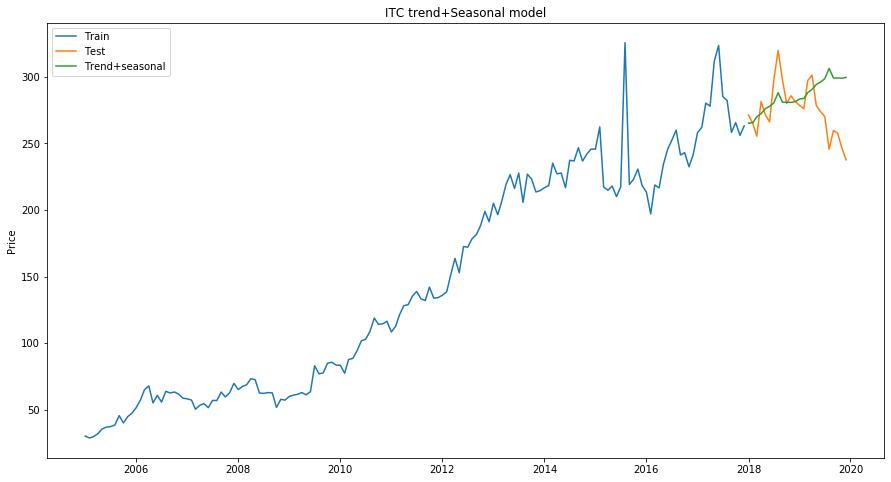

In [28]:
plt.figure(figsize=(15,8))
plt.plot(train.Close,label='Train')
plt.plot(test.Close,label='Test')
plt.plot(yhat['Winter_Trend_seasonal'],label='Trend+seasonal')
plt.ylabel('Price')
plt.title('ITC trend+Seasonal model')
plt.legend(loc='best')

In [29]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test.Close, yhat['Winter_Trend_seasonal'])
mse

728.7758343883175

# -----------------------Stationarity Test-------------------

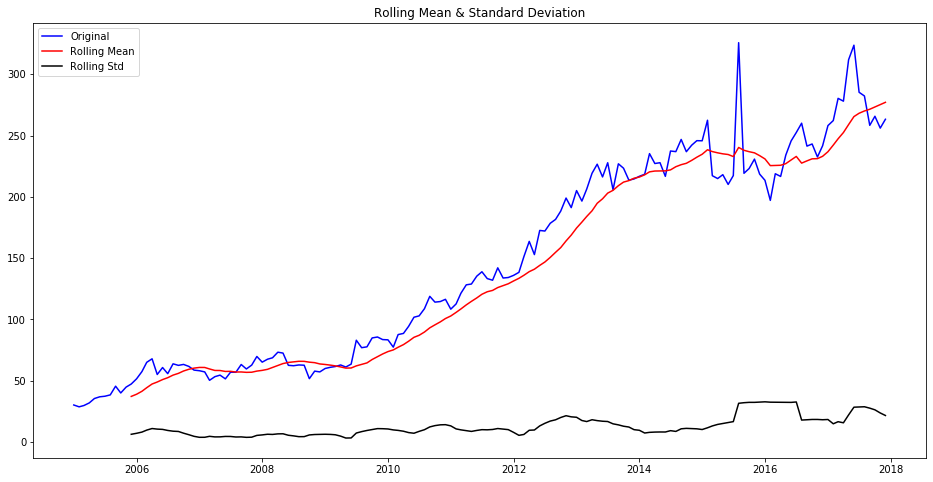

Results of Dickey-Fuller Test:
Test Statistic                  -1.145633
p-value                          0.696535
#Lags Used                       0.000000
Number of Observations Used    155.000000
Critical Value (1%)             -3.473259
Critical Value (5%)             -2.880374
Critical Value (10%)            -2.576812
dtype: float64


In [30]:
#Stationarity test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries,wind):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window = wind).mean()
    rolstd = timeseries.rolling(window = wind).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

plt.figure(figsize=(16,8))
test_stationarity(train['Close'],12)

In [31]:
#----------------Another method to check stationarity----------------------------
from statsmodels.tsa.stattools import kpss


# KPSS Test
result = kpss(train.Close.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')


KPSS Statistic: 1.112501
p-value: 0.010000
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


C:\Users\manur\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


Text(0.5, 1.0, 'Closing Price detrended by subtracting the trend component')

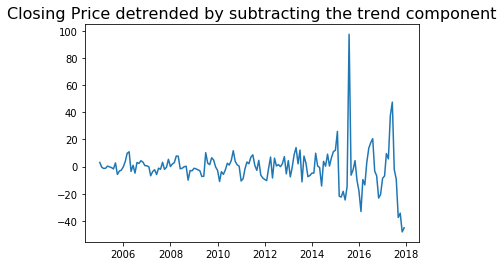

In [32]:
#----------------------Detrending-----------------
result_mul = seasonal_decompose(train['Close'], model='multiplicative', extrapolate_trend='freq')
detrended = train.Close.values - result_mul.trend
plt.plot(detrended)
plt.title('Closing Price detrended by subtracting the trend component', fontsize=16)

[]

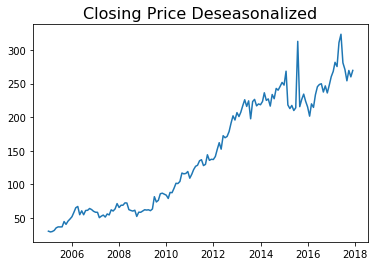

In [33]:
#------------------- Deseasonalizing-----------------
deseasonalized = train.Close.values / result_mul.seasonal

# Plot
plt.plot(deseasonalized)
plt.title('Closing Price Deseasonalized', fontsize=16)
plt.plot()

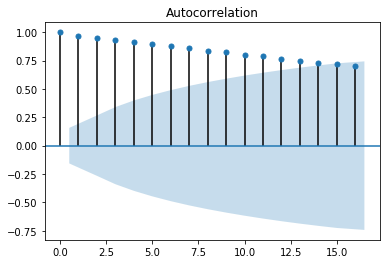

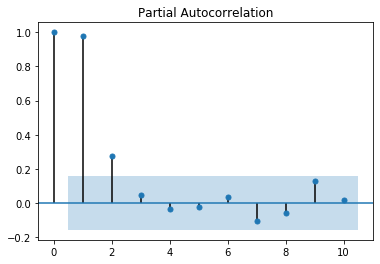

In [34]:
import statsmodels.graphics as sg
from statsmodels.graphics.tsaplots import plot_pacf

lag_acf = sg.tsaplots.plot_acf(train.Close.dropna(),lags=16)
lag_pacf=plot_pacf(train.Close.dropna(), lags=10)

# -----------------------------------------Auto ARIMA model---------------------

In [35]:
import pmdarima as pm

In [36]:
from pmdarima.arima.utils import ndiffs

# Estimate the number of differences using an ADF test:
n_adf = ndiffs(train.Close, test='adf')  

# Or a KPSS test (auto_arima default):
n_kpss = ndiffs(train.Close, test='kpss') 

In [37]:
n_diffs = max(n_adf, n_kpss)
n_diffs

1

In [38]:
auto = pm.auto_arima(train.Close, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1271.791, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1296.556, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1273.858, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1268.554, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1295.979, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1269.985, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1270.311, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1272.110, Time=0.06 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 2.019 seconds


In [39]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape

In [40]:
model = auto

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in test.Close:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Mean squared error: {mean_squared_error(test.Close, forecasts)}")
print(f"SMAPE: {smape(test.Close, forecasts)}")

Mean squared error: 248.0389574270896
SMAPE: 4.776760269050266


In [41]:
future = pd.Series(forecasts,index=test.index)

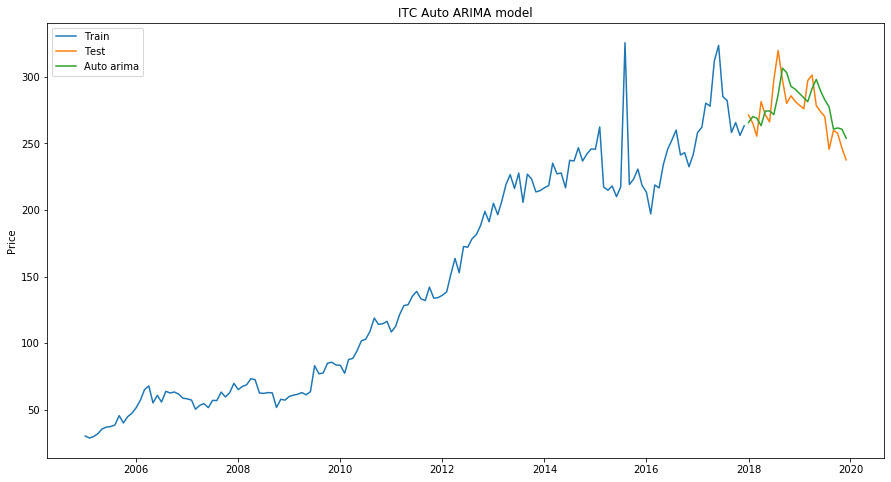

In [42]:
plt.figure(figsize=(15,8))
plt.plot(train.Close,label='Train')
plt.plot(test.Close,label='Test')
plt.plot(future,label='Auto arima')
plt.ylabel('Price')
plt.title('ITC Auto ARIMA model')
plt.legend(loc='best')

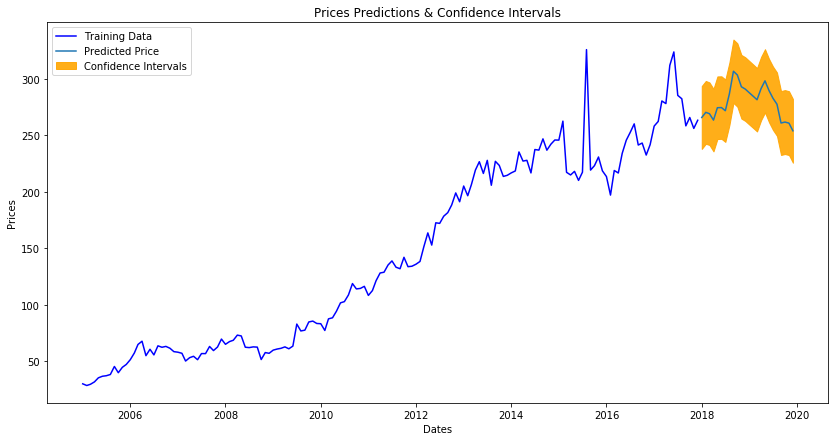

In [43]:
# ------------------ Predicted with confidence intervals ----------------
plt.figure(figsize=(14,7))
plt.plot(train.Close, color='blue', label='Training Data')
plt.plot(test.index, forecasts,label='Predicted Price')

plt.title('Prices Predictions & Confidence Intervals')
plt.xlabel('Dates')
plt.ylabel('Prices')

conf_int = np.asarray(confidence_intervals)
plt.fill_between(test.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

plt.legend()